# Testing LOSD
### Bevölkerung nach Zivilstand, Geschlecht, Alter und Stadtquartier

Zivilstand der Bevölkerung nach Geschlecht, Alter und Stadtquartier, seit 1993.
https://data.integ.stadt-zuerich.ch/dataset/bev331od3310 

Datum: 26.03.2024

### Colab
Mit Colab kann das Jupyter-Notebook interaktiv im Browser gestartet werden. 

Klicke auf den Button:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/DonGoginho/colab/blob/main/losd/3310_losd_bev_bestand_jahr_quartier_zivilstand_ag_geschl_od3310.ipynb)


### Importiere die notwendigen Packages

In [1]:
#%pip install altair datetime folium geopandas io requests matplotlib numpy pandas seaborn plotly

In [1]:
import altair as alt
import datetime
import folium 
import geopandas as gpd
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pivottablejs
#from pivottablejs import pivot_ui
import plotly.express as px
import requests
import seaborn as sns

In [2]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [3]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [4]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Setze einige Pfadvariabeln

**BITTE HIER ANPASSEN**

In [5]:
package_name = "bev331od3310"
package_name = package_name.upper()
print(package_name)

BEV331OD3310


In [6]:
dataset_name = "bev331od3310.csv"

**Statische Pfade CKAN-URLs**

In [7]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/"
ld_integ_url ="https://ld.integ.stadt-zuerich.ch/statistics/view/"

In [8]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"
ld_prod_url ="https://ld.stadt-zuerich.ch/statistics/view/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [9]:
from IPython.display import Markdown as md

In [10]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name.lower()))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/bev331od3310 

In [11]:
md(" **2. Dataset auf INTEG-LD:** Link {} ".format(ld_integ_url+package_name.upper()))

 **2. Dataset auf INTEG-LD:** Link https://ld.integ.stadt-zuerich.ch/statistics/view/BEV331OD3310 

In [12]:
md(" **3. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name.lower()))

 **3. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bev331od3310 

In [13]:
md(" **4. Dataset auf PROD-LD:** Link {} ".format(ld_prod_url+package_name.upper()))

 **4. Dataset auf PROD-LD:** Link https://ld.stadt-zuerich.ch/statistics/view/BEV331OD3310 

### Setze ein paar Zeitvariabeln
Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe [Link](https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime)
Zuerst die Zeitvariabeln als Strings

In [14]:
now = datetime.date.today()
year_today = now.strftime("%Y")

Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [15]:
int_times = now.timetuple()
aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2
#print(aktuellesJahr, aktuellerMonat,'datenstand: ', selectedMonat, int_times)

### Importiere den Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [16]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "int"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

int - web


In [17]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            #fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = ckan_prod_url+package_name+'/download/'+dataset_name
        fp = ld_prod_url+package_name+'/observation?format=csv'
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        #fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = ckan_integ_url+package_name+'/download/'+dataset_name
        fp = ld_integ_url+package_name+'/observation?format=csv'
        print("fp lautet:"+fp)


fp lautet:https://ld.integ.stadt-zuerich.ch/statistics/view/BEV331OD3310/observation?format=csv


In [18]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['StichtagDatJahr']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['ZEIT_lang']
        ,low_memory=False)
    print("web")

data2betested.dtypes
#data2betested

web


ZEIT_lang        datetime64[ns]
ZEIT_code                object
RAUM_lang                object
RAUM_code                object
ALT_lang                 object
ALT_code                 object
SEX_lang                 object
SEX_code                 object
ZIV_lang                 object
ZIV_code                 object
BEW                     float64
KreiseZH_lang            object
KreiseZH_code            object
dtype: object

Berechne weitere Attribute falls notwendig

In [19]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        StichtagDatJahr = lambda x: x.ZEIT_lang,
        StichtagDatJahr_str = lambda x: x.ZEIT_lang.astype(str),
        Jahr = lambda x: x.ZEIT_lang.dt.year,
        #Jahr_nbr = lambda x: x.ZEIT_code.str[-4:].astype(int),    
        RAUM_my_sort = lambda x: x.RAUM_code.str[-3:].astype(int),

    )
    .sort_values('ZEIT_lang', ascending=False)
    )
data2betested

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,ALT_lang,ALT_code,SEX_lang,...,BEW,KreiseZH_lang,KreiseZH_code,StichtagDatJahr,StichtagDatJahr_str,Jahr,RAUM_my_sort
37264,2022-12-31,Z31122022,Werd,R00041,49 Jahre alt,ALT0049,männlich,...,5,Kreis 4 (ab 1915),R00700,2022-12-31,2022-12-31,2022,41
175365,2022-12-31,Z31122022,Unterstrass,R00061,52 Jahre alt,ALT0052,weiblich,...,3,Kreis 6 (ab 1934),R01200,2022-12-31,2022-12-31,2022,61
100628,2022-12-31,Z31122022,Affoltern,R00111,27 Jahre alt,ALT0027,männlich,...,244,Kreis 11 (ab 1970),R01800,2022-12-31,2022-12-31,2022,111
51217,2022-12-31,Z31122022,Rathaus,R00011,78 Jahre alt,ALT0078,weiblich,...,1,Kreis 1 (Stadtgebiet vor 1893),R10000,2022-12-31,2022-12-31,2022,11
100632,2022-12-31,Z31122022,Albisrieden,R00091,28 Jahre alt,ALT0028,weiblich,...,23,Kreis 9 (ab 1934),R01400,2022-12-31,2022-12-31,2022,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20838,1993-12-31,Z31121993,Rathaus,R00011,52 Jahre alt,ALT0052,männlich,...,11,Kreis 1 (Stadtgebiet vor 1893),R10000,1993-12-31,1993-12-31,1993,11
126752,1993-12-31,Z31121993,Unterstrass,R00061,81 Jahre alt,ALT0081,weiblich,...,70,Kreis 6 (ab 1934),R01200,1993-12-31,1993-12-31,1993,61
178643,1993-12-31,Z31121993,Albisrieden,R00091,56 Jahre alt,ALT0056,weiblich,...,16,Kreis 9 (ab 1934),R01400,1993-12-31,1993-12-31,1993,91
126737,1993-12-31,Z31121993,Rathaus,R00011,60 Jahre alt,ALT0060,männlich,...,7,Kreis 1 (Stadtgebiet vor 1893),R10000,1993-12-31,1993-12-31,1993,11


Zeitbereich aus den Daten:

In [22]:
data_max_date = str(max(data2betested.ZEIT_lang).year)
data_min_date = str(min(data2betested.ZEIT_lang).year)

print(f"Die Daten haben ein Minimumjahr von {data_min_date} und ein Maximumjahr von {data_max_date}")


Die Daten haben ein Minimumjahr von 1993 und ein Maximumjahr von 2022


### Einfache Datentests

In [23]:
data2betested.head(2).T

,37264,175365
ZEIT_lang,2022-12-31 00:00:00,2022-12-31 00:00:00
ZEIT_code,Z31122022,Z31122022
RAUM_lang,Werd,Unterstrass
RAUM_code,R00041,R00061
ALT_lang,49 Jahre alt,52 Jahre alt
ALT_code,ALT0049,ALT0052
SEX_lang,männlich,weiblich
SEX_code,SEX0001,SEX0002
ZIV_lang,Geschieden,Verwitwet
ZIV_code,ZIV0005,ZIV0004


In [24]:
data2betested.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203446 entries, 37264 to 47955
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ZEIT_lang            203446 non-null  datetime64[ns]
 1   ZEIT_code            203446 non-null  object        
 2   RAUM_lang            203446 non-null  object        
 3   RAUM_code            203446 non-null  object        
 4   ALT_lang             203446 non-null  object        
 5   ALT_code             203446 non-null  object        
 6   SEX_lang             203446 non-null  object        
 7   SEX_code             203446 non-null  object        
 8   ZIV_lang             203446 non-null  object        
 9   ZIV_code             203446 non-null  object        
 10  BEW                  203446 non-null  float64       
 11  KreiseZH_lang        203446 non-null  object        
 12  KreiseZH_code        203446 non-null  object        
 13  StichtagDat

In [25]:
print(f'The dataset has {data2betested.shape[0]:,.0f} rows (observations) and {data2betested.shape[1]:,.0f} columns (variables).')
print(f'There seem to be {data2betested.duplicated().sum()} exact duplicates in the data.')

The dataset has 203,446 rows (observations) and 17 columns (variables).
There seem to be 0 exact duplicates in the data.


Welches sind die Quartiere ohne Werte bei BEW?

In [26]:
data2betested[np.isnan(data2betested.BEW)]

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,ALT_lang,ALT_code,SEX_lang,...,BEW,KreiseZH_lang,KreiseZH_code,StichtagDatJahr,StichtagDatJahr_str,Jahr,RAUM_my_sort


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [27]:
data2betested = data2betested.set_index("StichtagDatJahr") 
data2betested = data2betested.sort_index()

In [28]:
data2betested.index.year.unique()

Int64Index([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
            2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
            2021, 2022],
           dtype='int64', name='StichtagDatJahr')

### Beschreibe einzelne Attribute

Beschreibe nicht numerische Attribute

In [29]:
# describe non-numerical features
try:
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        display(data2betested.describe(exclude='number',datetime_is_numeric=True))
except:
    print("No categorical data in dataset.")

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,ALT_lang,ALT_code,SEX_lang,SEX_code,ZIV_lang,ZIV_code,KreiseZH_lang,KreiseZH_code,StichtagDatJahr_str
count,203446,203446,203446,203446,203446,203446,203446,203446,203446,203446,203446,203446,203446
unique,NaN,30,12,12,108,108,2,2,7,7,12,12,30
top,NaN,Z31122021,Albisrieden,R00091,60 Jahre alt,ALT0060,weiblich,SEX0002,Ledig,ZIV0001,Kreis 9 (ab 1934),R01400,2021-12-31
freq,NaN,7165,18683,18683,2833,2833,105830,105830,64882,64882,18683,18683,7165
mean,2008-10-17 07:23:48.455708160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1993-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2000-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2008-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2015-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2022-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Beschreibe numerische Attribute

In [30]:
# describe numerical features
try:
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(data2betested.describe(include='number'))
except:
    print("No numercial data in dataset.")

,BEW,Jahr,RAUM_my_sort
count,"203,446","203,446","203,446"
mean,23,"2,008",67
std,31,9,34
min,0,"1,993",11
25%,3,"2,000",41
50%,9,"2,008",71
75%,28,"2,015",101
max,310,"2,022",121


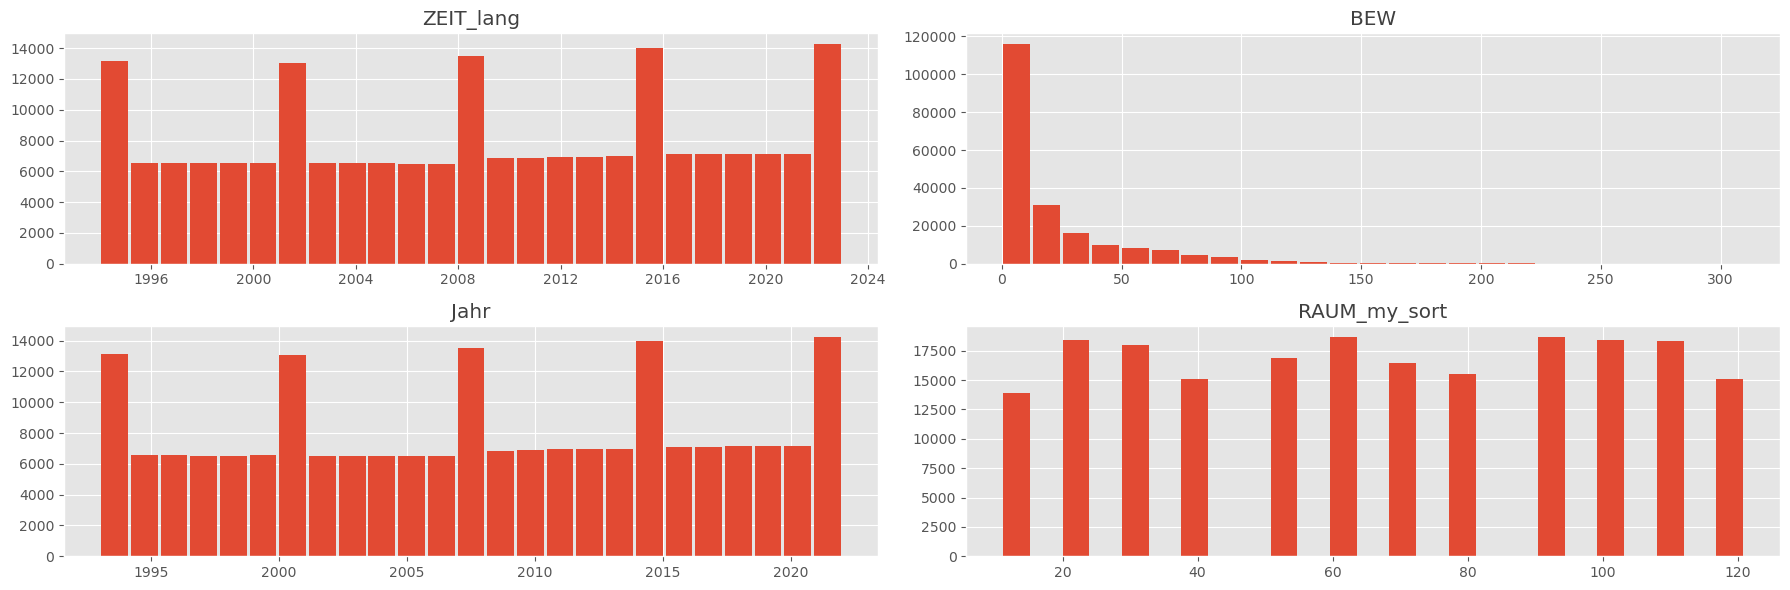

In [31]:
plt.style.use('ggplot')
params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }
plt.rcParams.update(params)

try:
    data2betested.hist(bins=25, rwidth=0.9)
    plt.tight_layout()
    plt.show()
except:
    print("No numercial data to plot.") 

### Gibt es Duplikate?

In [32]:
# find duplicate rows
duplicate_rows = data2betested[data2betested.duplicated()]
duplicate_rows

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,ALT_lang,ALT_code,SEX_lang,...,ZIV_code,BEW,KreiseZH_lang,KreiseZH_code,StichtagDatJahr_str,Jahr,RAUM_my_sort
StichtagDatJahr,,,,,,,,,,,,,,,


### Nullwerte und Missings?

In [33]:
data2betested.isnull().sum()

ZEIT_lang              0
ZEIT_code              0
RAUM_lang              0
RAUM_code              0
ALT_lang               0
ALT_code               0
SEX_lang               0
SEX_code               0
ZIV_lang               0
ZIV_code               0
BEW                    0
KreiseZH_lang          0
KreiseZH_code          0
StichtagDatJahr_str    0
Jahr                   0
RAUM_my_sort           0
dtype: int64

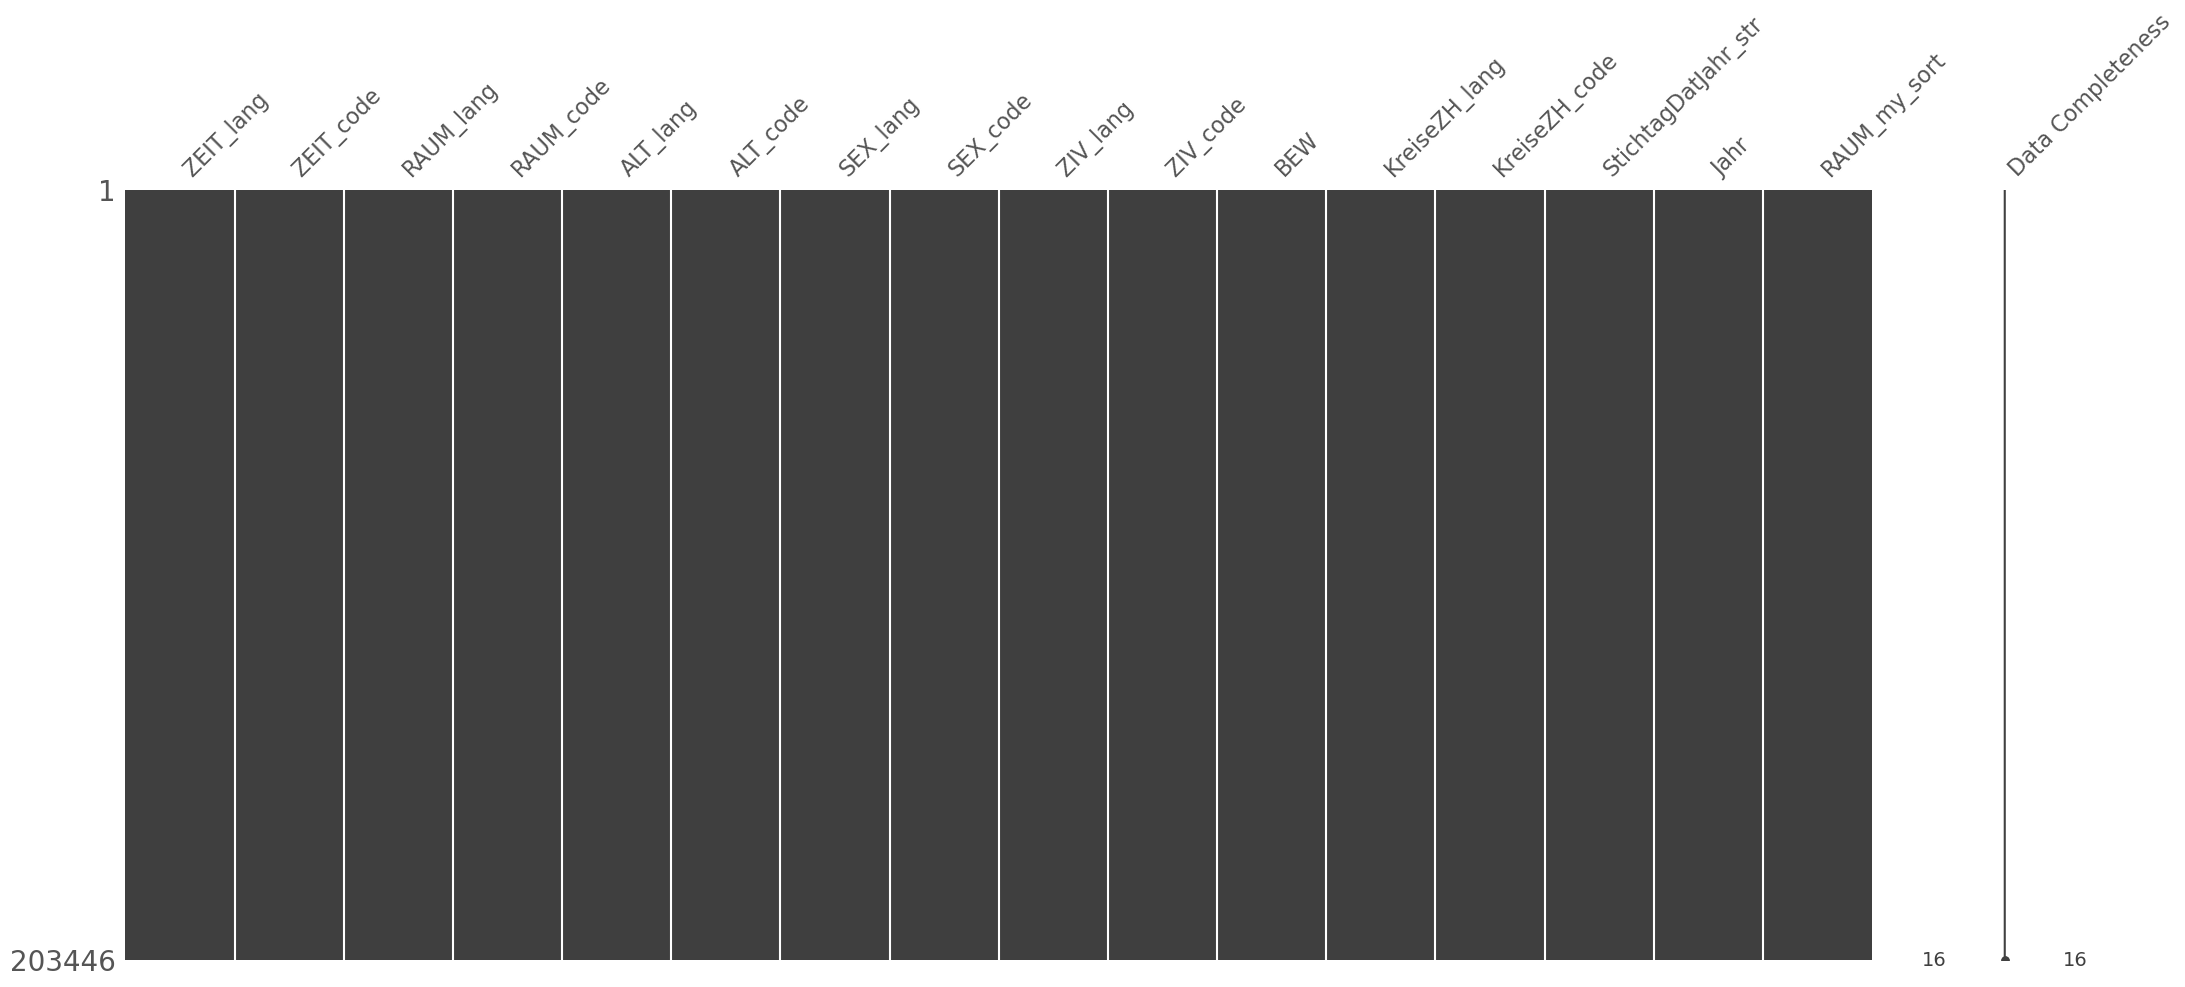

In [34]:
# check missing values with missingno
# https://github.com/ResidentMario/missingno
import missingno as msno
msno.matrix(data2betested, labels=True, sort='descending');
#msno.heatmap(data2betested)

### Gruppierungen

In [35]:
agg_jahr = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('Jahr', ascending=False) 
agg_jahr.reset_index().head(3)

,Jahr,sum_AnzBestWir
0,2022,179314
1,2021,176392
2,2020,175676


In [ ]:
agg_Quarts = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['RAUM_my_sort', 'RAUM_lang', 'RAUM_code']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('RAUM_code', ascending=False) 
agg_Quarts.reset_index().head(50)

In [40]:
agg_Alt = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['ALT_lang', 'ALT_code',]) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('ALT_code', ascending=False) 
agg_Alt.reset_index()

,ALT_lang,ALT_code,sum_AnzBestWir
0,107 Jahre alt,ALT0107,3
1,106 Jahre alt,ALT0106,7
2,105 Jahre alt,ALT0105,10
3,104 Jahre alt,ALT0104,32
4,103 Jahre alt,ALT0103,69
...,...,...,...
103,4 Jahre alt,ALT0004,41649
104,3 Jahre alt,ALT0003,43393
105,2 Jahre alt,ALT0002,45209
106,1 Jahr alt,ALT0001,47650


In [44]:
agg_Alt = data2betested.loc[data_max_date]\
    .groupby(['SEX_lang','SEX_code',]) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('SEX_code', ascending=False) 
agg_Alt.reset_index()

,SEX_lang,SEX_code,sum_AnzBestWir
0,weiblich,SEX0002,90070
1,männlich,SEX0001,89244


In [45]:
agg_Ziv = data2betested.loc[data_max_date]\
    .groupby(['ZIV_lang', 'ZIV_code',]) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('ZIV_code', ascending=False) 
agg_Ziv.reset_index()

,ZIV_lang,ZIV_code,sum_AnzBestWir
0,Unbekannt,ZIV0099,26
1,Aufgelöste Partnerschaft,ZIV0007,209
2,In eingetragener Partnerschaft,ZIV0006,704
3,Geschieden,ZIV0005,14036
4,Verwitwet,ZIV0004,5661
5,Verheiratet,ZIV0003,54847
6,Ledig,ZIV0001,103831


In [47]:
agg_Kreise = data2betested.loc[data_max_date]\
    .groupby(['KreiseZH_lang', 'KreiseZH_code']) \
    .agg(sum_AnzBestWir=('BEW', 'sum')) \
    .sort_values('KreiseZH_code', ascending=True) 
agg_Kreise.reset_index()

,KreiseZH_lang,KreiseZH_code,sum_AnzBestWir
0,Kreis 2 (ab 1893),R00200,20570
1,Kreis 3 (ab 1915),R00600,18079
2,Kreis 4 (ab 1915),R00700,4515
3,Kreis 5 (ab 1915),R00800,9663
4,Kreis 8 (ab 1915),R01100,5815
5,Kreis 6 (ab 1934),R01200,24953
6,Kreis 7 (ab 1934),R01300,8946
7,Kreis 9 (ab 1934),R01400,22875
8,Kreis 10 (ab 1934),R01500,24807
9,altes Quartier Schwamendingen (1934-1969); Kre...,R01700,8826


In [37]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'ALT_lang', 'ALT_code', 'SEX_lang',
       'SEX_code', 'ZIV_lang', 'ZIV_code', 'BEW', 'KreiseZH_lang', 'KreiseZH_code',
       'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [48]:
data2betested.loc[data_max_date].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,ZEIT_lang,ZEIT_code,RAUM_lang,RAUM_code,ALT_lang,ALT_code,SEX_lang,...,ZIV_code,BEW,KreiseZH_lang,KreiseZH_code,StichtagDatJahr_str,Jahr,RAUM_my_sort
StichtagDatJahr,,,,,,,,,,,,,,,
2022-12-31,2022-12-31,Z31122022,Seefeld,R00081,90 Jahre alt,ALT0090,weiblich,...,ZIV0003,1,Kreis 8 (ab 1915),R01100,2022-12-31,2022,81
2022-12-31,2022-12-31,Z31122022,Albisrieden,R00091,57 Jahre alt,ALT0057,weiblich,...,ZIV0003,54,Kreis 9 (ab 1934),R01400,2022-12-31,2022,91


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Wohnbevölkerung seit ...

In [51]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'ALT_lang', 'ALT_code', 'SEX_lang',
       'SEX_code', 'ZIV_lang', 'ZIV_code', 'BEW', 'KreiseZH_lang', 'KreiseZH_code',
       'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

In [52]:
myAggAll = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr','ZEIT_lang', 'ZEIT_code',]) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=False) 

myAggAll.reset_index().head(1)

,StichtagDatJahr,ZEIT_lang,ZEIT_code,sum_WBev
0,2022-12-31,2022-12-31,Z31122022,179314


In [53]:
myTitle="Bevölkerungsentwicklung, seit "+str(data2betested.index.year.min())

highlight = alt.selection(type='single', on='mouseover',
                          fields=['sum_WBev'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAggAll.reset_index().query('sum_WBev>30'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    #, color=alt.Color('QuarLang', legend=alt.Legend(title="Altersgruppen", orient="right"))  
    ,tooltip=['StichtagDatJahr','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung Wohnbevölkerung nach Stadtquartier seit ...

In [40]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'BEW', 'KreiseZH_lang', 'KreiseZH_code',
       'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

In [81]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr', 'RAUM_lang', 'RAUM_code']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg.reset_index().head(3)

,StichtagDatJahr,RAUM_lang,RAUM_code,sum_WBev
0,1993-12-31,Affoltern,R00111,18095
1,1993-12-31,Wollishofen,R00021,15927
2,1993-12-31,Werd,R00041,4048


In [82]:

myTitle="Bevölkerung nach Stadtquartier, seit "+str(data2betested.index.year.min())
highlight = alt.selection(type='single', on='mouseover',
                          fields=['RAUM_lang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_WBev>30'), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('RAUM_lang', legend=alt.Legend(title="Stadtquartier", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'RAUM_lang','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung Wohnbevölkerung nach Zivilstand 

In [83]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg2 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr', 'ZIV_lang', 'ZIV_code']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg2.reset_index().head(5)


,StichtagDatJahr,ZIV_lang,ZIV_code,sum_WBev
0,1993-12-31,Geschieden,ZIV0005,10358
1,1993-12-31,Ledig,ZIV0001,60122
2,1993-12-31,Verheiratet,ZIV0003,60314
3,1993-12-31,Verwitwet,ZIV0004,10612
4,1994-12-31,Geschieden,ZIV0005,10441


In [60]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'ALT_lang', 'ALT_code', 'SEX_lang',
       'SEX_code', 'ZIV_lang', 'ZIV_code', 'BEW', 'KreiseZH_lang', 'KreiseZH_code',
       'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

In [84]:
myTitle="Entwicklung Wohnbevölkerung nach Zivilstand, seit "+str(data2betested.index.year.min())

highlight = alt.selection(type='single', on='mouseover',
                          fields=['ZIV_lang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg2.reset_index(), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('ZIV_lang', legend=alt.Legend(title="Zivilstand", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'ZIV_lang','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung der Wohnbevölkerung nach Geschlecht

In [87]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg3 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr', 'SEX_lang','SEX_code', ]) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg3.reset_index().head(5)


,StichtagDatJahr,SEX_lang,SEX_code,sum_WBev
0,1993-12-31,männlich,SEX0001,67498
1,1993-12-31,weiblich,SEX0002,73908
2,1994-12-31,männlich,SEX0001,67536
3,1994-12-31,weiblich,SEX0002,73755
4,1995-12-31,männlich,SEX0001,67360


In [ ]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'ALT_lang', 'ALT_code', 'SEX_lang',
       'SEX_code', 'ZIV_lang', 'ZIV_code', 'BEW', 'KreiseZH_lang', 'KreiseZH_code',
       'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

In [91]:
myTitle="Entwicklung Wohnbevölkerung nach Geschlecht, seit "+str(data2betested.index.year.min())

highlight = alt.selection(type='single', on='mouseover',
                          fields=['SEX_lang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg3.reset_index(), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('SEX_lang', legend=alt.Legend(title="Geschlecht", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'SEX_lang','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung der Wohnbevölkerung nach Alter

In [92]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg4 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr', 'ALT_lang', 'ALT_code']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg4.reset_index().head(5)


,StichtagDatJahr,ALT_lang,ALT_code,sum_WBev
0,1993-12-31,0 Jahre alt,ALT0000,1304
1,1993-12-31,73 Jahre alt,ALT0073,1375
2,1993-12-31,72 Jahre alt,ALT0072,1403
3,1993-12-31,71 Jahre alt,ALT0071,1422
4,1993-12-31,70 Jahre alt,ALT0070,1508


In [ ]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'ALT_lang', 'ALT_code', 'SEX_lang',
       'SEX_code', 'ZIV_lang', 'ZIV_code', 'BEW', 'KreiseZH_lang', 'KreiseZH_code',
       'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

In [93]:
myTitle="Entwicklung Wohnbevölkerung nach Alter, seit "+str(data2betested.index.year.min())

highlight = alt.selection(type='single', on='mouseover',
                          fields=['ALT_lang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg4.reset_index(), title=myTitle).encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_WBev', axis=alt.Axis(title='Anz. Personen'))
    , color=alt.Color('ALT_lang', legend=alt.Legend(title="Zivilstand", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'ALT_lang','sum_WBev']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [94]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested.loc["2018":data_max_date]\
    .groupby(['StichtagDatJahr','Jahr', 'RAUM_lang', 'RAUM_code']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAggBar.reset_index().head(3)

,StichtagDatJahr,Jahr,RAUM_lang,RAUM_code,sum_WBev
0,2018-12-31,2018,Affoltern,R00111,26562
1,2018-12-31,2018,Wollishofen,R00021,18923
2,2018-12-31,2018,Werd,R00041,4455


In [46]:
#help(sns.catplot)     

In [77]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

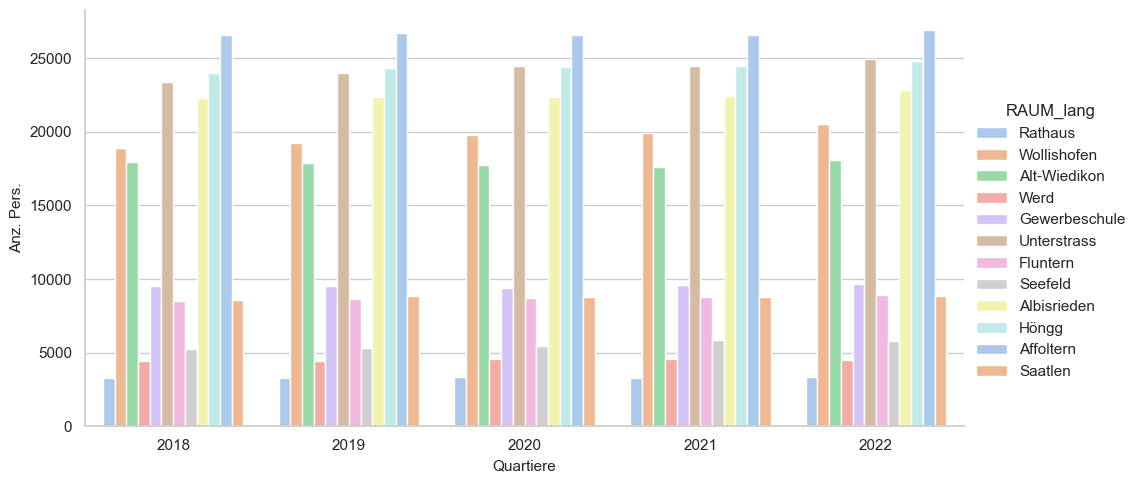

In [95]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Jahr"
            , y="sum_WBev"
            , hue="RAUM_lang"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index().sort_values("RAUM_code", ascending=True)
           )
myHist.set_xlabels('Quartiere', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Pers.', fontsize=11)


#### Facet Grids

##### Wohnbevölkerung nach Stadtquartier

In [79]:
myFG = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr','StichtagDatJahr_str', 'RAUM_lang', 'RAUM_code', 'RAUM_my_sort']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('RAUM_my_sort', ascending=True) 

myFG

,,,,,sum_WBev
Jahr,StichtagDatJahr_str,RAUM_lang,RAUM_code,RAUM_my_sort,
2010,2010-12-31,Rathaus,R00011,11,3099
2012,2012-12-31,Rathaus,R00011,11,3164
2011,2011-12-31,Rathaus,R00011,11,3140
2009,2009-12-31,Rathaus,R00011,11,3110
1995,1995-12-31,Rathaus,R00011,11,3049
...,...,...,...,...,...
2015,2015-12-31,Saatlen,R00121,121,8508
1996,1996-12-31,Saatlen,R00121,121,6384
2014,2014-12-31,Saatlen,R00121,121,7563


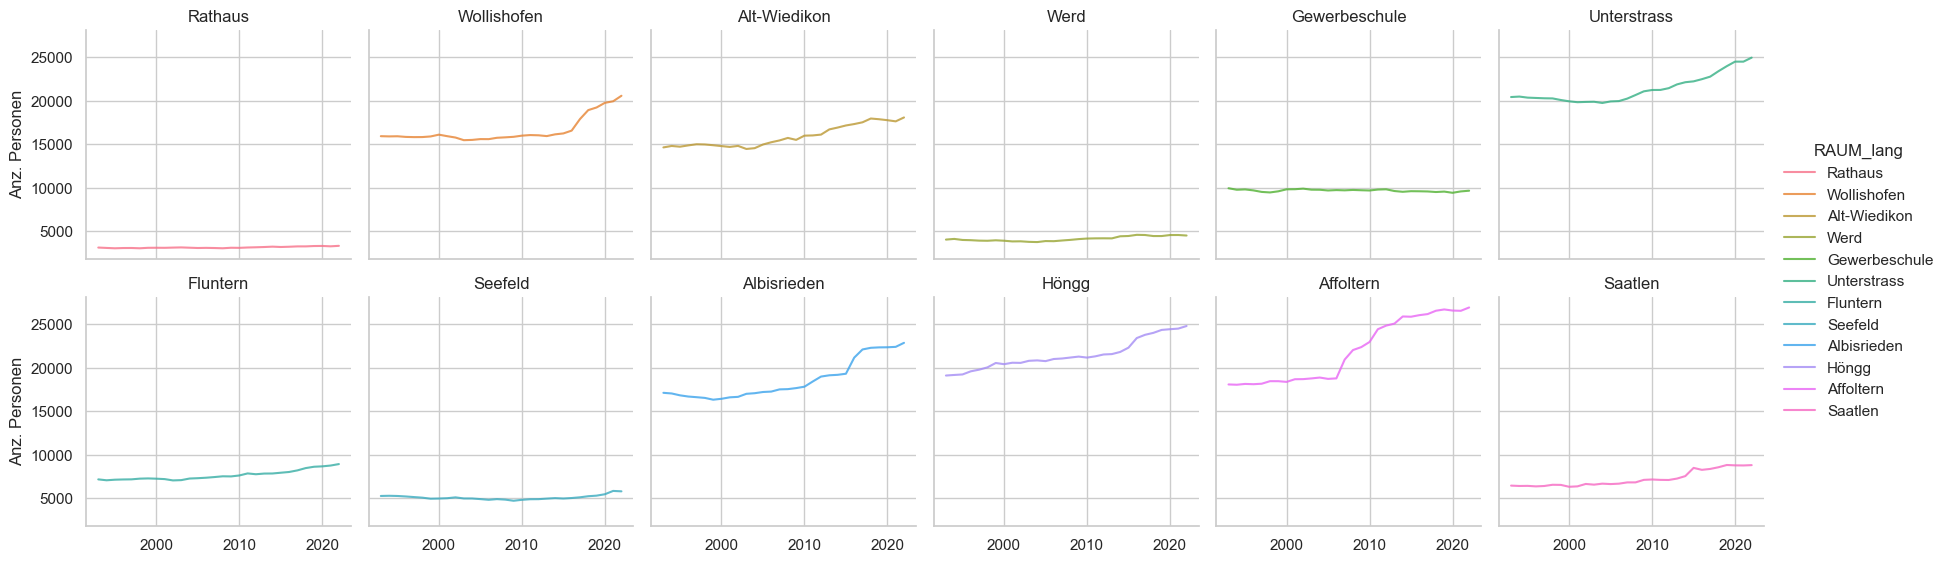

In [80]:
g2 = sns.FacetGrid(myFG.reset_index(), col="RAUM_lang", hue="RAUM_lang", col_wrap=6, height=3,)
g2.map(sns.lineplot, "Jahr","sum_WBev",alpha=.8)

g2.set_axis_labels("","Anz. Personen")
g2.set_titles(col_template="{col_name}", row_template="{row_name}")

g2.add_legend()


##### Wohnbevölkerung nach Alter und Zivilstand

**Hinweis**: Eine Gruppierung in Altersgruppen (z.B. wie bisher AlterV10 Zehnjahresgruppen) wäre hier sinnvoll. Da es keine numerischen Codes gibt, ist eine eigene Altersgruppe zu erstellen etwas mühsam...

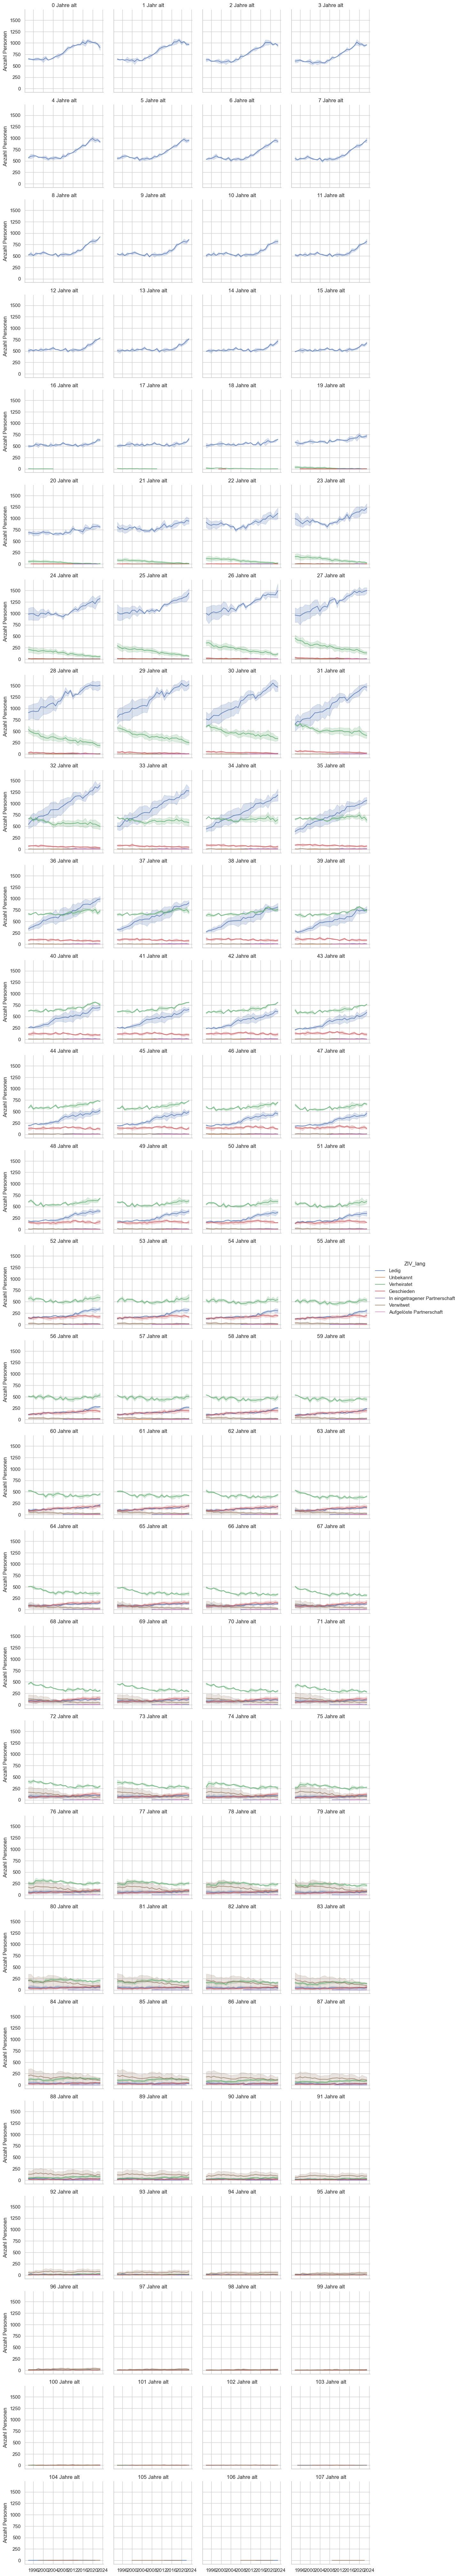

In [98]:
g3 = sns.FacetGrid(myFG2.reset_index().sort_values('ALT_code', ascending=True), col="ALT_lang", hue="ZIV_lang", col_wrap=4, height=3,)
g3.map(sns.lineplot, "StichtagDatJahr","sum_WBev",alpha=.8)

g3.set_axis_labels("","Anzahl Personen")
g3.set_titles(col_template="{col_name}", row_template="{row_name}")

g3.add_legend()

### Daten in interaktiver Treemap zeigen

In [99]:
data2betested.columns

Index(['ZEIT_lang', 'ZEIT_code', 'RAUM_lang', 'RAUM_code', 'ALT_lang', 'ALT_code', 'SEX_lang',
       'SEX_code', 'ZIV_lang', 'ZIV_code', 'BEW', 'KreiseZH_lang', 'KreiseZH_code',
       'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

In [102]:
myTreemapAgg = data2betested.loc['2020':data_max_date]  \
    .groupby(['StichtagDatJahr', 'SEX_lang','SEX_code', 'ZIV_lang', 'ZIV_code']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('sum_WBev', ascending=True) 

In [112]:
my_Title = "Wohnbevölkerung nach Zivilstand und Geschlecht"

fig = px.treemap(myTreemapAgg.reset_index(), path=[px.Constant(my_Title), 'StichtagDatJahr', 'SEX_lang', 'ZIV_lang']
                 , values='sum_WBev'
                 , color='ZIV_lang'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'Ausländer/in':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }         
                 , color_discrete_map={'(?)':'lightgrey','Schweizer/in':'gold', 'SP':'#FF3030' }               
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='blues'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])   
                 ,height=600
                 ,width=1100
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.data[0].hovertemplate = '%{label}<br><br>AnzPers:<br>%{value}<extra></extra>'
fig.show()

In [106]:
myTreemapAgg2 = data2betested.loc[data_max_date]  \
    .groupby(['StichtagDatJahr', 'SEX_lang','SEX_code', 'ZIV_lang', 'ZIV_code','KreiseZH_lang']) \
    .agg(sum_WBev=('BEW', 'sum')) \
    .sort_values('sum_WBev', ascending=True) 

In [111]:
my_Title = "Wohnbevölkerung nach Sstadtkreis, Zivilstand und Geschlecht, "+data_max_date

fig = px.treemap(myTreemapAgg2.reset_index(), path=[px.Constant(my_Title), 'KreiseZH_lang', 'ZIV_lang','SEX_lang']
                 , values='sum_WBev'
                 , color='ZIV_lang'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'Ausländer/in':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }         
                 , color_discrete_map={'(?)':'lightgrey','Schweizer/in':'gold', 'SP':'#FF3030' }               
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='blues'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])   
                 ,height=600
                 ,width=1100
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.data[0].hovertemplate = '%{label}<br><br>AnzPers:<br>%{value}<extra></extra>'
fig.show()

## ---------------------- hier Plausi beendet

Übersicht zu LOSD-Jobs:
[Sharepoint](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/OGD%20Metadaten.aspx#InplviewHasheb69a2c0-ed94-4ef2-91a5-3b19f038e442=FilterField1%3DMetadaten%255Fx002d%255FPublikations%255Fx00-FilterValue1%3DINT)